In [ ]:
# import required librarires
import tensorflow as tf

print(tf.__version__)

import numpy as np

2.9.2


In [ ]:
# import matplotlib for plotting
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [ ]:
# set random seed to ensure reproducibility
tf.random.set_seed(42)  

In [ ]:
# passed to build a random imagge initially
codings_size = 30

In [18]:
# create function for plots

def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

In [ ]:
# create an instance for Dense module from layers package in Keras library
Dense = tf.keras.layers.Dense

# generator part is similar to decoder in autoencoders
# generator is typicaly a neural network that constructs an image from noise
# Note: generator is trained through full GAN model and does not require compliation
generator = tf.keras.Sequential([
    Dense(100, activation="relu", kernel_initializer="he_normal"),
    Dense(150, activation="relu", kernel_initializer="he_normal"),
    Dense(28 * 28, activation="sigmoid"),
    tf.keras.layers.Reshape([28, 28])
])

In [ ]:
# discriminator part
# discriminator is a classifier that takes input image from generator and classifies if it is fake or real
discriminator = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    Dense(150, activation="relu", kernel_initializer="he_normal"),
    Dense(100, activation="relu", kernel_initializer="he_normal"),
    Dense(1, activation="sigmoid")
])



In [ ]:
# combine generator and discriminator to construct a simple GAN
gan = tf.keras.Sequential([generator, discriminator])

In [ ]:
# discriminator has binary_crossentropy as loss
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")

# discriminator should not be trainable after the first run
discriminator.trainable = False

# the gan model is binary classifier
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [ ]:
# load the fashion MNIST data
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
# create a Dataset to iterate through the images

# set the batch size
batch_size = 32

# shuffle and read the training data
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)

# prefetch the data as per batch size
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

Epoch 1/10


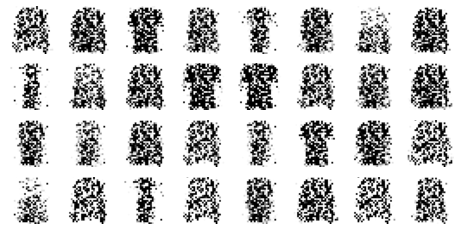

Epoch 2/10


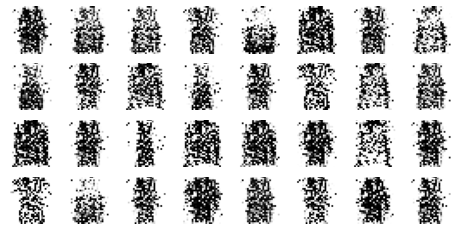

Epoch 3/10


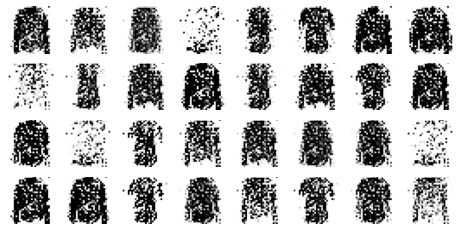

Epoch 4/10


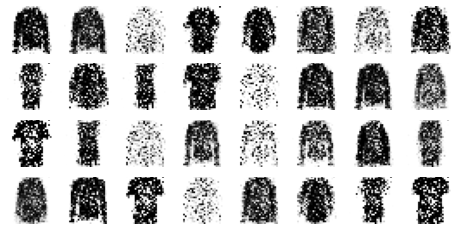

Epoch 5/10


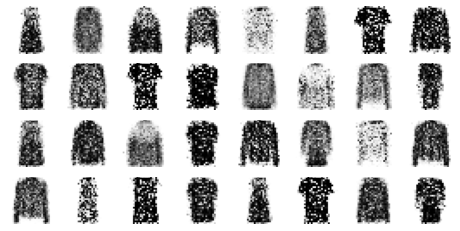

Epoch 6/10


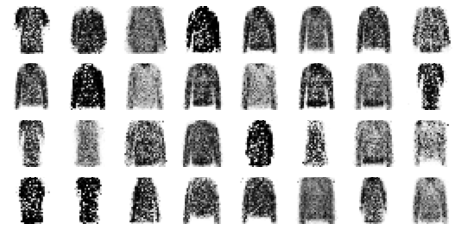

Epoch 7/10


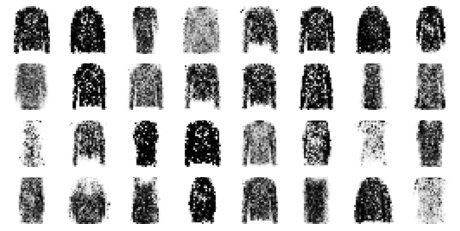

Epoch 8/10


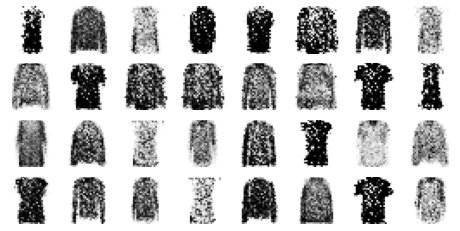

Epoch 9/10


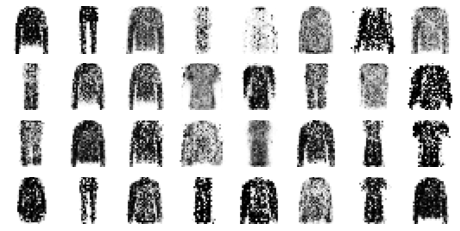

Epoch 10/10


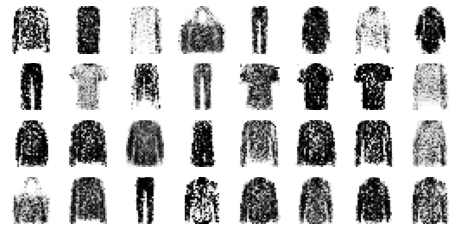

In [ ]:
# the training loop is unusual, cannot use the regular fit() method. 
# Instead, write a custom training loop.

# train GAN
def train_gan(gan, dataset, batch_size, codings_size, n_epochs):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print(f"Epoch {epoch + 1}/{n_epochs}")  # extra code
        for X_batch in dataset:
            # phase 1 - training the discriminator
              ## feed Gaussian noise to the generator to produce fake images
            noise = tf.random.normal(shape=[batch_size, codings_size])

            # generate images from noise
            generated_images = generator(noise)

            # concat gake and real images
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)

            # The targets y1 are set to 0 for fake images and 1 for real images. 
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)

            # train the discriminator on this batch. 
            # the discriminator is trainable in this phase, but do not touching the generator.
            discriminator.train_on_batch(X_fake_and_real, y1)


            # phase 2 - training the generator

              # feed random noise to GAN
            noise = tf.random.normal(shape=[batch_size, codings_size])

            # In this phase,the GAN model trying to improve the generator implying the discriminator to fail: 
            # this is why the targets y2 are all set to 1, although the images are fake. 
            y2 = tf.constant([[1.]] * batch_size)

            # generator will start by producing fake images
            # then the discriminator will try to guess whether these images are fake or real
            # In this phase, the discriminator is not trainable 
            # so the only part of the gan model that will improve is the generator
            gan.train_on_batch(noise, y2)


        # extra code — plot images during training
        plot_multiple_images(generated_images.numpy(), 8)
        plt.show()





train_gan(gan, dataset, batch_size, codings_size, n_epochs=10)

## Run it for 50 epochs and review if the simple GAN is managing to create images of fashion MNIST.

In [ ]:
# After training, randomly sample some codings from a Gaussian distribution, 
# and feed them to the generator to produce new images:

codings = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator.predict(codings)

1/1 [==============================] - 0s 83ms/step


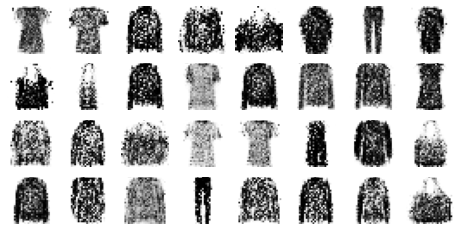

In [ ]:
plot_multiple_images(generated_images, 8)
plt.show()